In [14]:
!nvidia-smi

Thu Sep 17 08:40:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |   1033MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
!pip install -U fastai
!pip install lshashpy3

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.13)


In [16]:
from fastai.vision.all import *
import pickle
import lshashpy3 as lshash
from tqdm import tqdm_notebook
import PIL.Image

In [26]:
#importing the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
cd drive/My\ Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [27]:
root_path = Path('.')
data_path = Path('data_512')
model_path = Path('Models')

In [20]:
size = 512
lr = defaults.lr
bs = 32

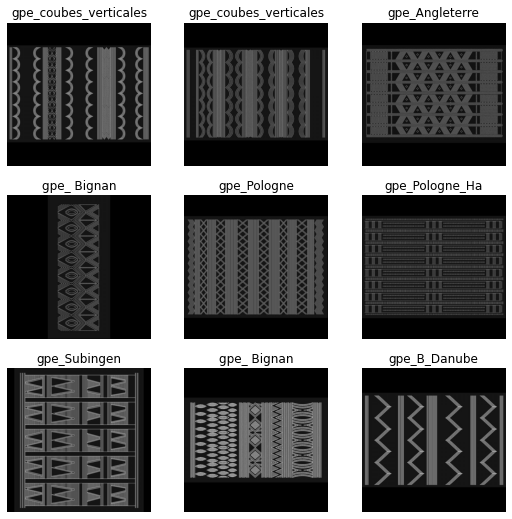

In [39]:
batch_transforms = aug_transforms(mult=1.0,
                                  do_flip=True,
                                  flip_vert=True,
                                  max_rotate=0.0, 
                                  min_zoom=1.0,
                                  max_zoom=1.0,
                                  max_lighting=0.0,
                                  max_warp=0.0,
                                  p_affine=0.75, 
                                  p_lighting=0.75,
                                  xtra_tfms=None,
                                  size=size,
                                  mode='bilinear',
                                  pad_mode='reflection',
                                  align_corners=True, 
                                  batch=True,
                                  min_scale=1.0)

db = DataBlock(blocks = (ImageBlock, CategoryBlock),
               get_items = get_image_files,
               splitter = RandomSplitter(valid_pct=0.2, seed=42),
               get_y = parent_label,
               item_tfms = Resize(size),
               batch_tfms = [*batch_transforms, Normalize()]
               )

data = db.dataloaders(data_path, bs=bs)
data.show_batch(max_n=9)



In [40]:
learner = cnn_learner(data,
                      resnet50,
                      metrics = error_rate,
                      pretrained = True,
                      bn_wd = False,
                      loss_func = LabelSmoothingCrossEntropy(),
                      cbs = [BnFreeze,
                              SaveModelCallback(monitor='error_rate', name='best_error'),
                              ShowGraphCallback],
                      model_dir = model_path
                      ).to_fp16()


In [41]:
learner.load('stage-2');

In [42]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():

    features=None

    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
            
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learner.model[1][5]) ## Output before the last FC layer

In [ ]:
data.train_ds

In [43]:
## By running this feature vectors would be saved in sf variable initated above
_= learner.get_preds(0)
# _= learner.get_preds(DatasetType.Valid)

In [44]:
#Converting in a dictionary of {img_path:featurevector}
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [ ]:
len(next(iter(feature_dict.items()))[1])

In [ ]:
len(feature_dict)

In [45]:
## Exporting as pickle
pickle.dump(feature_dict, open("Models/feature_dict.p", "wb"))

In [46]:
## Loading Feature dictionary
feature_dict = pickle.load(open("Models/feature_dict.p",'rb'))

In [47]:
## Locality Sensitive Hashing
# params
k = 30 # hash size
L = 3  # number of tables
d = 512 # Dimension of Feature vector
lsh = lshash.LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()): #tqdm is for the progressbar
    lsh.index(vec.flatten(), extra_data=img_path)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [48]:
## Exporting as pickle
pickle.dump(lsh, open("Models/lsh.p", "wb"))